##This script is created based on [Emotion-Detection-using-fine-tuned-BERT-Transformer](https://github.com/SayamAlt/Emotion-Detection-using-fine-tuned-BERT-Transformer/blob/main/Emotion%20Detection%20using%20fine-tuned%20BERT.ipynb) done by Sayam Kumar


In [ ]:
!pip install transformers==4.31.0 #to fix the Typeerror problem #https://stackoverflow.com/questions/78129126/typeerror-exception-encountered-when-calling-layer-embeddings-type-tfbertemb
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModelForMaskedLM, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import custom_object_scope
from google.colab import drive
from tensorflow.keras import regularizers

In [ ]:
# Load the CSV file into a DataFrame
file_path = 'https://raw.githubusercontent.com/Letieateat/Sentiment-Analysis-on-Traditional-Chinese-Lyrics/main/dataset/final_sentiments.csv'
df = pd.read_csv(file_path)

# Select only the specific columns
df = df[['final_lyrics', 'human_2']]

# Split the data into three sets: 70%, 15%, and 15%
train, temp = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Rename the 'final_lyrics' column to 'Input' in the DataFrames
train = train.rename(columns={'final_lyrics': 'Input'})
val = val.rename(columns={'final_lyrics': 'Input'})
test = test.rename(columns={'final_lyrics': 'Input'})

# Save the three sets into separate CSV files
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

##Combining the train, validation and test datasets into a single dataframe

In [ ]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,human_2
0,310,打開 片 窗 伸出 雙手 載浮載沉 吹過 抹 風 親近 不得不 發生 距離 越 活 越 枯悶...,Positive
1,357,離開 不會 太 悲傷 心情 釋放 眼淚 落下 發現 騙不了 其實 愛 現在 學 遺忘 躲開 ...,Negative
2,146,想要 直昇機 想要 妳 飛到 宇宙 想要 妳 融化 在一起 融化 銀河 裡 天 天 天 想想...,Positive
3,134,奔騰 馬蹄 小妹妹 吹 口琴 夕陽 美 剪影 子彈 寫 日記 介紹完 風景 接下來 換 介紹...,Positive
4,654,像是 小數點 第幾 位 存在 自動 省略 習慣 避嫌 看作 算 夠 謹慎 類 踏 逾越 條 ...,Negative


In [ ]:
df.drop('index',axis=1,inplace=True)

In [ ]:
df.shape

(100, 2)

In [ ]:
df['num_words'] = df.Input.apply(len)

In [ ]:
df.head()

,Input,human_2,num_words
0,打開 片 窗 伸出 雙手 載浮載沉 吹過 抹 風 親近 不得不 發生 距離 越 活 越 枯悶...,Positive,134
1,離開 不會 太 悲傷 心情 釋放 眼淚 落下 發現 騙不了 其實 愛 現在 學 遺忘 躲開 ...,Negative,64
2,想要 直昇機 想要 妳 飛到 宇宙 想要 妳 融化 在一起 融化 銀河 裡 天 天 天 想想...,Positive,187
3,奔騰 馬蹄 小妹妹 吹 口琴 夕陽 美 剪影 子彈 寫 日記 介紹完 風景 接下來 換 介紹...,Positive,172
4,像是 小數點 第幾 位 存在 自動 省略 習慣 避嫌 看作 算 夠 謹慎 類 踏 逾越 條 ...,Negative,122


In [ ]:
encoded_labels = {'Negative': 0, 'Positive': 1}

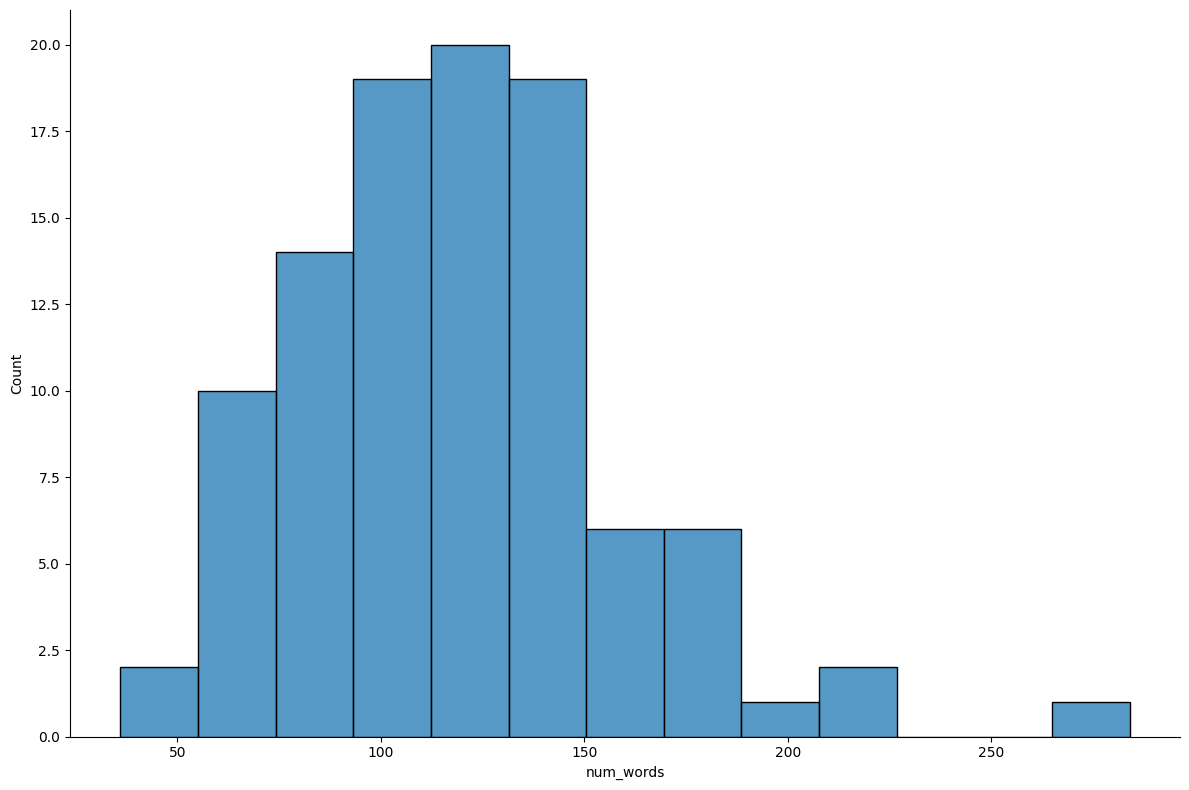

In [ ]:
sns.displot(df.num_words,height=8,aspect=1.5)

##Text Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
bert_model = TFBertModel.from_pretrained("bert-base-chinese")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
X_train = tokenizer(text=train.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   #max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_val = tokenizer(text=val.Input.tolist(),
                  add_special_tokens=True,
                  return_tensors='tf',
                  #max_length=max_len,
                  padding=True,
                  truncation=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  verbose=True
                 )

X_test = tokenizer(text=test.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   #max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

##Defining the model architecture

In [ ]:
input_ids = Input(shape=(None,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(None,),name='attention_mask',dtype=tf.int32)

In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
#output = Dropout(0.1)(output) #first dropout layer
output = Dense(units=64,activation='relu', kernel_regularizer=regularizers.l2(0.2))(output)
#output = Dense(units=64,activation='relu')(output)
#output = Dropout(0.2)(output) #second dropout layer
#output = Dense(units=32,activation='relu')(output)
output = Dense(units=32,activation='relu', kernel_regularizer=regularizers.l2(0.3))(output)
#output = Dropout(0.3)(output) #third dropout layer
y = Dense(units=2,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

##Compiling the model

In [ ]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=[CategoricalAccuracy()])

##Encoding the emotion labels

In [ ]:
train['Label'] = train.human_2.map(encoded_labels)
val['Label'] = val.human_2.map(encoded_labels)
test['Label'] = test.human_2.map(encoded_labels)

In [ ]:
train.head()

,Input,human_2,Label
440,相約 來到 世上 途中 失散 走 路 片 豔陽 忽然 預感 久違 陌生人 遇上 也許 笑 弧...,Positive,1
482,朋友 沒 笑 夢 種 安慰 不會 痛 放棄 理由 理直氣壯 背後 惶恐 世界 缺 偉大 成功...,Negative,0
422,天 想 信任 樣子 信任 臉 畫 艷麗 粧 眼神 天真 信任 其實 抽絲剝繭 詮釋 深入淺出...,Positive,1
780,愛 愛 心 滿 傷痕 犯 犯 錯 心 滿 悔恨 嚐盡 生活 苦 找 相信 感到 萬分 沮喪 ...,Negative,0
951,正在 休息 路 問 接下來 幹嘛 沙灘 大海 森林 清爽 沒關係 感覺 執著 想要 快 不要...,Positive,1


In [ ]:
test.head()

,Input,human_2,Label
259,知道 明偉 重量 平凡 擁有 無限 幻想 好像 很多 樣 好像 很多 你我 樣端 懂 抬 價...,Positive,1
858,次 徘徊 孤單 堅強 次 受傷 閃 淚光 知道 一直 雙 隱形 翅膀 帶 飛飛 絕望 想 擁...,Positive,1
906,撲火 相視 笑 撲火 真 相視 笑 夢 快樂 穿越 愛 歷史 走來 眼 裡 看盡 相戀 年代...,Positive,1
615,到底 笑 虛偽 能夠 融入 世界 臉 貼 張 假面 想 想 想 想 靈魂 深處 到底 發生 ...,Negative,0
296,寄 地址 信 情緒 有種 距離 放 歌曲 心情 能不能 聽 雨 安靜 偷偷 哭泣 幸福 真的...,Negative,0


##Generating the model summary and plot

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1022676   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, None,                                        

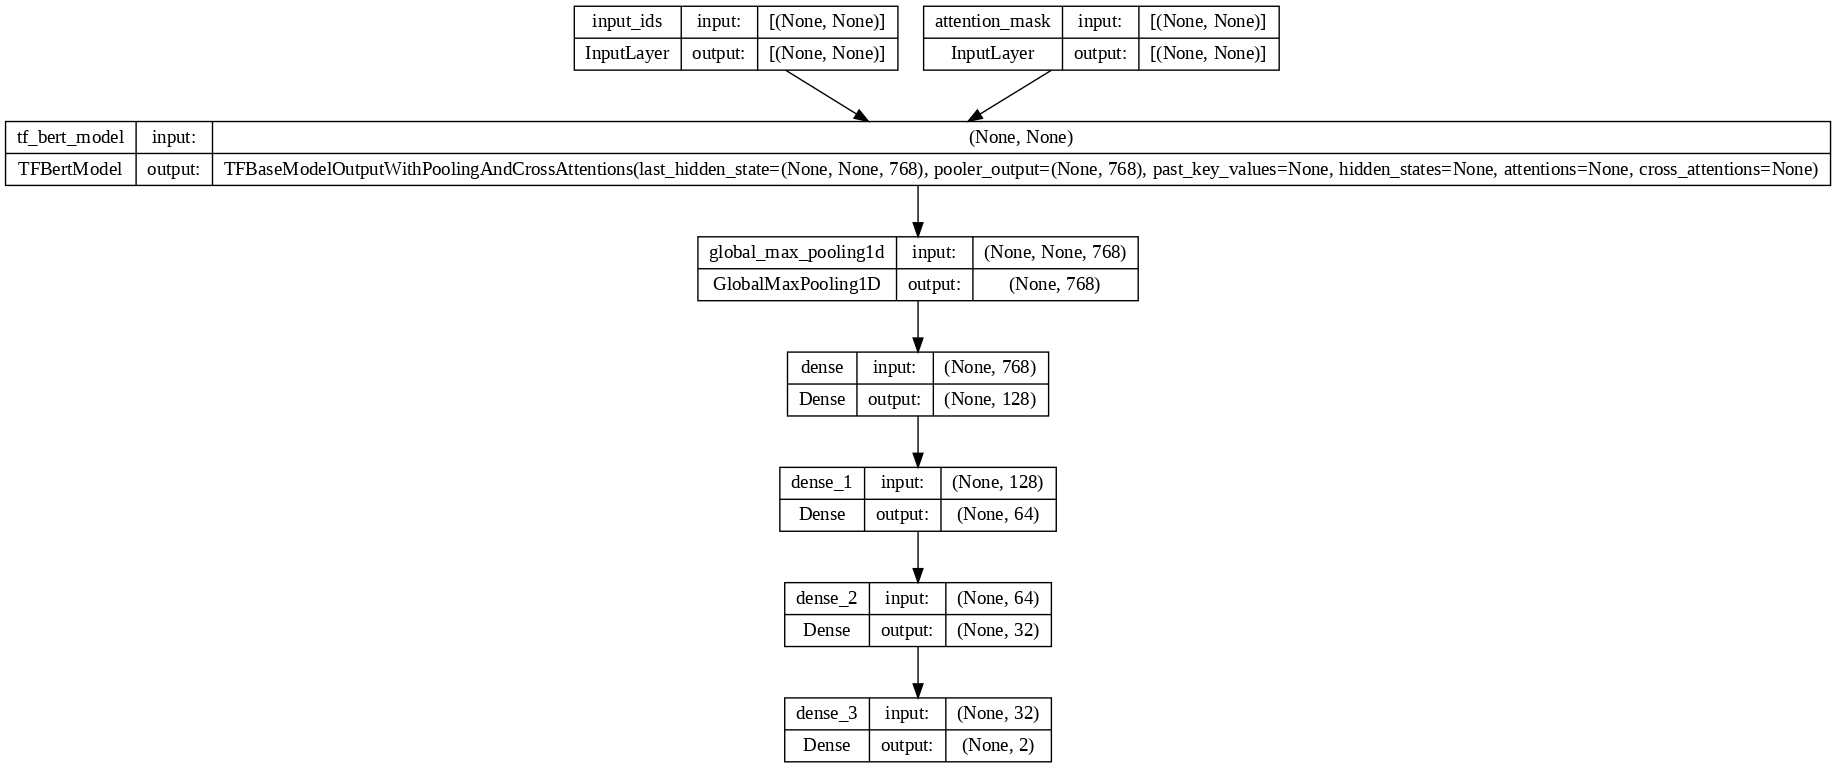

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

##Training and fine-tuning the pretrained BERT model

In [ ]:
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=True, mode='max')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', save_best_only=True, mode='max')

In [ ]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train.Label, num_classes=2),
             epochs=10,
             batch_size=16,
             validation_data=({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']},
                  to_categorical(val.Label)),callbacks=[early_stopping,checkpoint]
             )

Epoch 1/10


44/44 [==============================] - 80s 1s/step - loss: 30.2231 - categorical_accuracy: 0.5464 - val_loss: 29.8320 - val_categorical_accuracy: 0.3800
Epoch 2/10
44/44 [==============================] - 50s 1s/step - loss: 29.5163 - categorical_accuracy: 0.5777 - val_loss: 29.2279 - val_categorical_accuracy: 0.6200
Epoch 3/10
44/44 [==============================] - 31s 711ms/step - loss: 29.0158 - categorical_accuracy: 0.5806 - val_loss: 28.7931 - val_categorical_accuracy: 0.6200
Epoch 4/10
44/44 [==============================] - 32s 720ms/step - loss: 28.5970 - categorical_accuracy: 0.5720 - val_loss: 28.4179 - val_categorical_accuracy: 0.6200
Epoch 5/10
44/44 [==============================] - 40s 909ms/step - loss: 28.2183 - categorical_accuracy: 0.6534 - val_loss: 28.0519 - val_categorical_accuracy: 0.7867
Epoch 6/10
44/44 [==============================] - 32s 719ms/step - loss: 27.8582 - categorical_accuracy: 0.7546 - val_loss: 27.8457 - val_categorical_accuracy: 0.6200
Epo


##Analyzing model performance

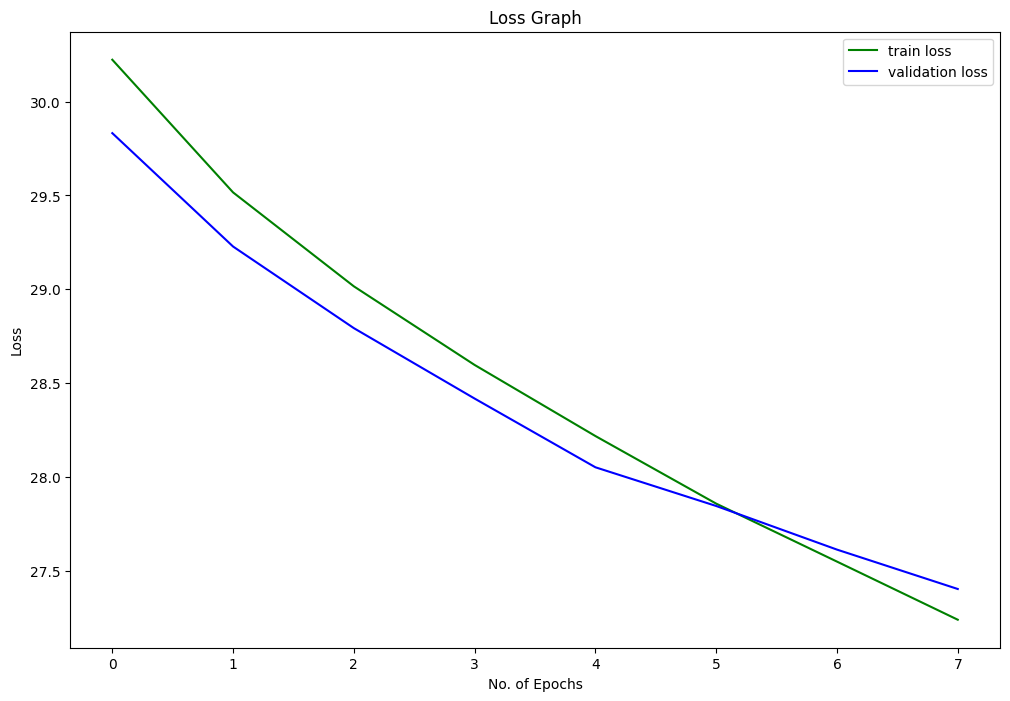

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'g',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')

plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

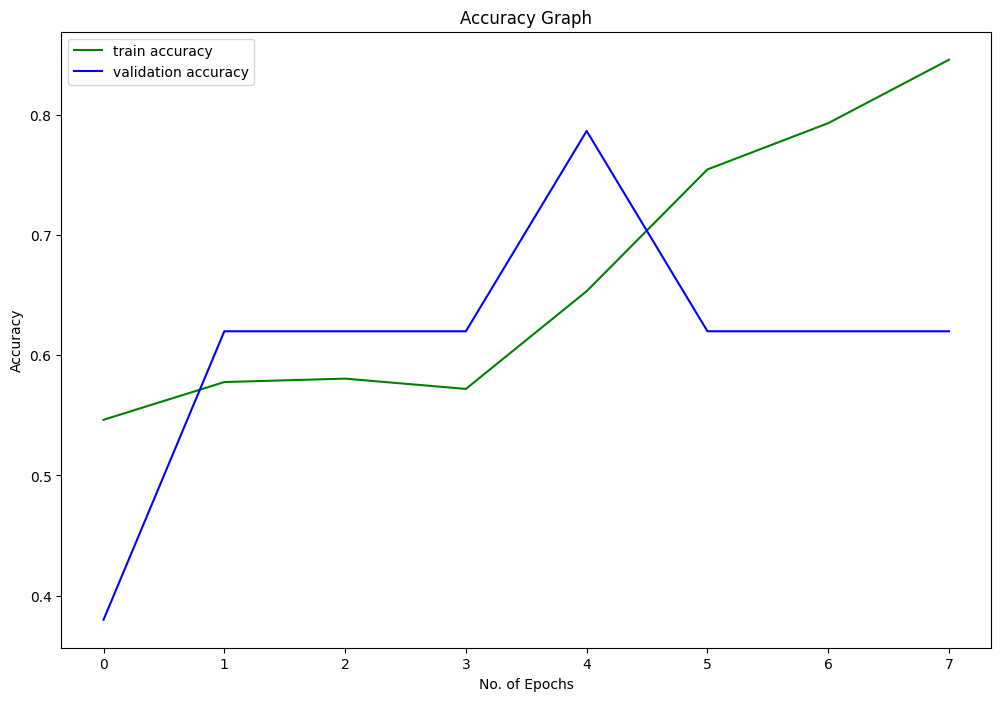

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['categorical_accuracy'],'g',label='train accuracy')
plt.plot(r.history['val_categorical_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
with custom_object_scope({'TFBertModel': TFBertModel}):
  best_model = load_model('best_model.h5')

##Save the model (Google drive)

In [ ]:
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/TFM/bert_2_2&3drop.h5'
best_model.save(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = 'bert_2.h5'
best_model.save(model_path)

##Load the model

##Evaluating the model on the test dataset

In [ ]:
loss, acc = best_model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test.Label, num_classes=2))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

5/5 [==============================] - 5s 375ms/step - loss: 28.1300 - categorical_accuracy: 0.7020
Test Categorical Cross-Entropy Loss: 28.130027770996094
Test Categorical Accuracy: 0.7019867300987244


In [ ]:
test_predictions = best_model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test.Label,test_predictions))

5/5 [==============================] - 5s 371ms/step
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        97
           1       0.58      0.61      0.59        54

    accuracy                           0.70       151
   macro avg       0.68      0.68      0.68       151
weighted avg       0.71      0.70      0.70       151



In [ ]:
incorrect_preds = []

for idx, (actual, predicted) in enumerate(zip(test.Label, test_predictions)):
    if actual != predicted:
        incorrect_preds.append({
            'Index': idx,
            'Actual': actual,
            'Predicted': predicted,
            'Input Text': tokenizer.decode(X_test['input_ids'][idx])
        })

if incorrect_preds:
    df_incorrect = pd.DataFrame(incorrect_preds)
    df_incorrect.to_csv('bert_2_errors.csv', index=False)
    print(f"Saved {len(incorrect_preds)} incorrect predictions to 'bert_2_errors.csv'")
else:
    print("No incorrect predictions to save.")

Saved 37 incorrect predictions to 'bert_2_errors.csv'
